In [38]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
source("../../../figures/utils/figure_themes.r")


In [ ]:
# set up argument parser
parser <- arg_parser("Plot the results of the multi-classification experiment.")
parser <- add_argument(parser, "--cell_type", help="Cell type to plot.")
parser <- add_argument(parser, "--model_name", help="Model name to plot.")

# parse arguments
args <- parse_args(parser)

# set up constants
cell_type <- args$cell_type
model_name <- args$model_name


In [39]:
cell_type <- "PBMC"
model_name <- "MultiClass_MLP"

In [40]:
# set file path for importing the data
training_metrics_file <- file.path(paste0(
    "../../results/Multi_Class/",model_name,"/",cell_type,"/training_metrics.csv"
))
confusion_matrix_file <- file.path(paste0(
    "../../results/Multi_Class/",model_name,"/",cell_type,"/confusion_matrices.csv"
))

# set output file path for graphs
f1_plot_path <- file.path(paste0(
    "../../figures/Multi_Class/",model_name,"/",cell_type,"/f1_score.png"
))

confusion_matrix_plot_path <- file.path(paste0(
    "../../figures/Multi_Class/",model_name,"/",cell_type,"/confusion_matrix.png"
))

# read in the data
training_metrics <- read.csv(training_metrics_file)
confusion_matrix <- read.csv(confusion_matrix_file)


In [41]:

support <- training_metrics[training_metrics$metric == "support",]
# get apoptosis, healthy, and pyroptosis support rows in one df
support <- support[support$label %in% c("apoptosis", "healthy", "pyroptosis"),]


In [42]:
# get the rows that contain the F1 scores
f1_scores <- training_metrics[training_metrics$metric == "f1-score",]
# remove the rows that contain the macro and weighted averages
f1_scores <- f1_scores[!grepl("macro avg", f1_scores$label),]
f1_scores <- f1_scores[!grepl("weighted avg", f1_scores$label),]
# muatate the label column for multiple cases
f1_scores$label <- gsub("healthy", "Healthy", f1_scores$label)
f1_scores$label <- gsub("apoptosis", "Apoptosis", f1_scores$label)
f1_scores$label <- gsub("pyroptosis", "Pyroptosis", f1_scores$label)
# mutate the data type column
f1_scores$group <- gsub("train", "Training", f1_scores$group)
f1_scores$group <- gsub("test", "Testing", f1_scores$group)
f1_scores$group <- gsub("validation", "Validation", f1_scores$group)
f1_scores$group <- gsub("holdout", "Holdout", f1_scores$group)
# factorize the group column
f1_scores$group <- factor(f1_scores$group, levels = c(
    "Training", "Validation", "Testing", "Holdout"
))
# mutate the shuffled_data column
f1_scores$shuffled_data <- gsub("True", "Shuffled", f1_scores$shuffled_data)
f1_scores$shuffled_data <- gsub("False", "Not Shuffled", f1_scores$shuffled_data)
# cbind the support column to the f1_scores df
f1_scores <- cbind(f1_scores, support$value)
# rename the support column
colnames(f1_scores)[colnames(f1_scores) == "support$value"] <- "support"
# dived the support by 10,000 to get the number of cells
f1_scores$support <- f1_scores$support / 10000
# round the support column to 2 decimal places
f1_scores$support <- round(f1_scores$support, 2)
# rename support column to support.10k
head(f1_scores)


,label,metric,value,group,shuffled_data,support
,<chr>,<chr>,<dbl>,<fct>,<chr>,<dbl>
13,Apoptosis,f1-score,0.05716392,Training,Shuffled,9.59
14,Healthy,f1-score,0.50250985,Training,Shuffled,68.38
15,Pyroptosis,f1-score,0.43677188,Training,Shuffled,63.73
37,Apoptosis,f1-score,0.05647470,Validation,Shuffled,2.40
38,Healthy,f1-score,0.50414029,Validation,Shuffled,17.10
39,Pyroptosis,f1-score,0.44016678,Validation,Shuffled,15.93


In [43]:
# make the label a factor so that the order is preserved
f1_scores$label <- factor(
    f1_scores$label, levels = c(
        "Healthy", "Apoptosis", "Pyroptosis"
        )
    )

F1 score  
### $F1 Score = 2 * \frac{precision * recall}{precision + recall}$
### $Precision = \frac{TP}{TP + FP}$
### $Recall = \frac{TP}{TP + FN}$
### $F1 Score = \frac{2 * TP}{2 * TP + FP + FN}$

In [44]:
head(f1_scores, 1)

,label,metric,value,group,shuffled_data,support
,<fct>,<chr>,<dbl>,<fct>,<chr>,<dbl>
13,Apoptosis,f1-score,0.05716392,Training,Shuffled,9.59


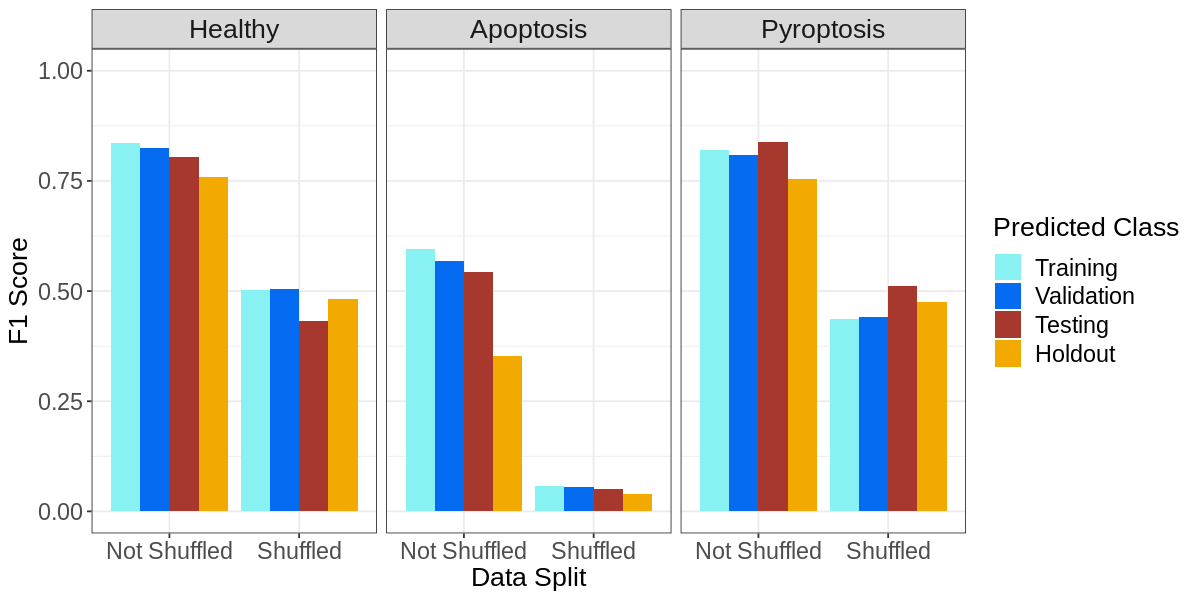

In [45]:
# set plot size
width <- 10
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the F1 scores
f1_score_plot <- (
    ggplot(f1_scores, aes(x = shuffled_data, y = value, fill = group))
    + geom_bar(stat = "identity", position = "dodge")

    + ylim(0, 1)
    + facet_wrap(~label)
    + ylab("F1 Score")
    + xlab("Data Split")
    # change the legend title
    + labs(fill = "Predicted Class")
    # change the colours
    + scale_fill_manual(values = c(
        "Training" = "#88F2F2",
        "Validation" = "#056CF2",
        "Testing" = "#A6382E",
        "Holdout" = "#F2A900"
    ))
    + figure_theme_wide

)
ggsave(f1_plot_path, f1_score_plot, width = width, height = height, dpi = 600)
f1_score_plot


#### Confusion Matrix data plot

In [46]:
# round the Recall vlaues to 2 decimal places
confusion_matrix$Recall <- round(confusion_matrix$Recall, 2)
# mutate the label column for multiple cases
confusion_matrix$True_Label <- gsub("healthy", "Healthy", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$True_Label)
confusion_matrix$Predicted_Label <- gsub("healthy", "Healthy", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$Predicted_Label)

# make the True Label and Predicted Label columns factors
confusion_matrix$True_Label <- factor(
    confusion_matrix$True_Label, levels = c(
        "Healthy", "Apoptosis", "Pyroptosis"
        )
    )
confusion_matrix$Predicted_Label <- factor(
    confusion_matrix$Predicted_Label, levels = c(
       "Pyroptosis", "Apoptosis", "Healthy"
        )
    )
    

# mutate the shuffled_data column
confusion_matrix$shuffled_data <- gsub("True", "Shuffled", confusion_matrix$shuffled_data)
confusion_matrix$shuffled_data <- gsub("False", "Not Shuffled", confusion_matrix$shuffled_data)
# mutate the data type column
confusion_matrix$data_split <- gsub("testing", "Testing", confusion_matrix$data_split)
confusion_matrix$data_split <- gsub("holdout", "Hold Out Wells", confusion_matrix$data_split)
# make the data split column a factor
confusion_matrix$data_split <- factor(confusion_matrix$data_split, levels = c(
    "Testing", "Hold Out Wells"
))


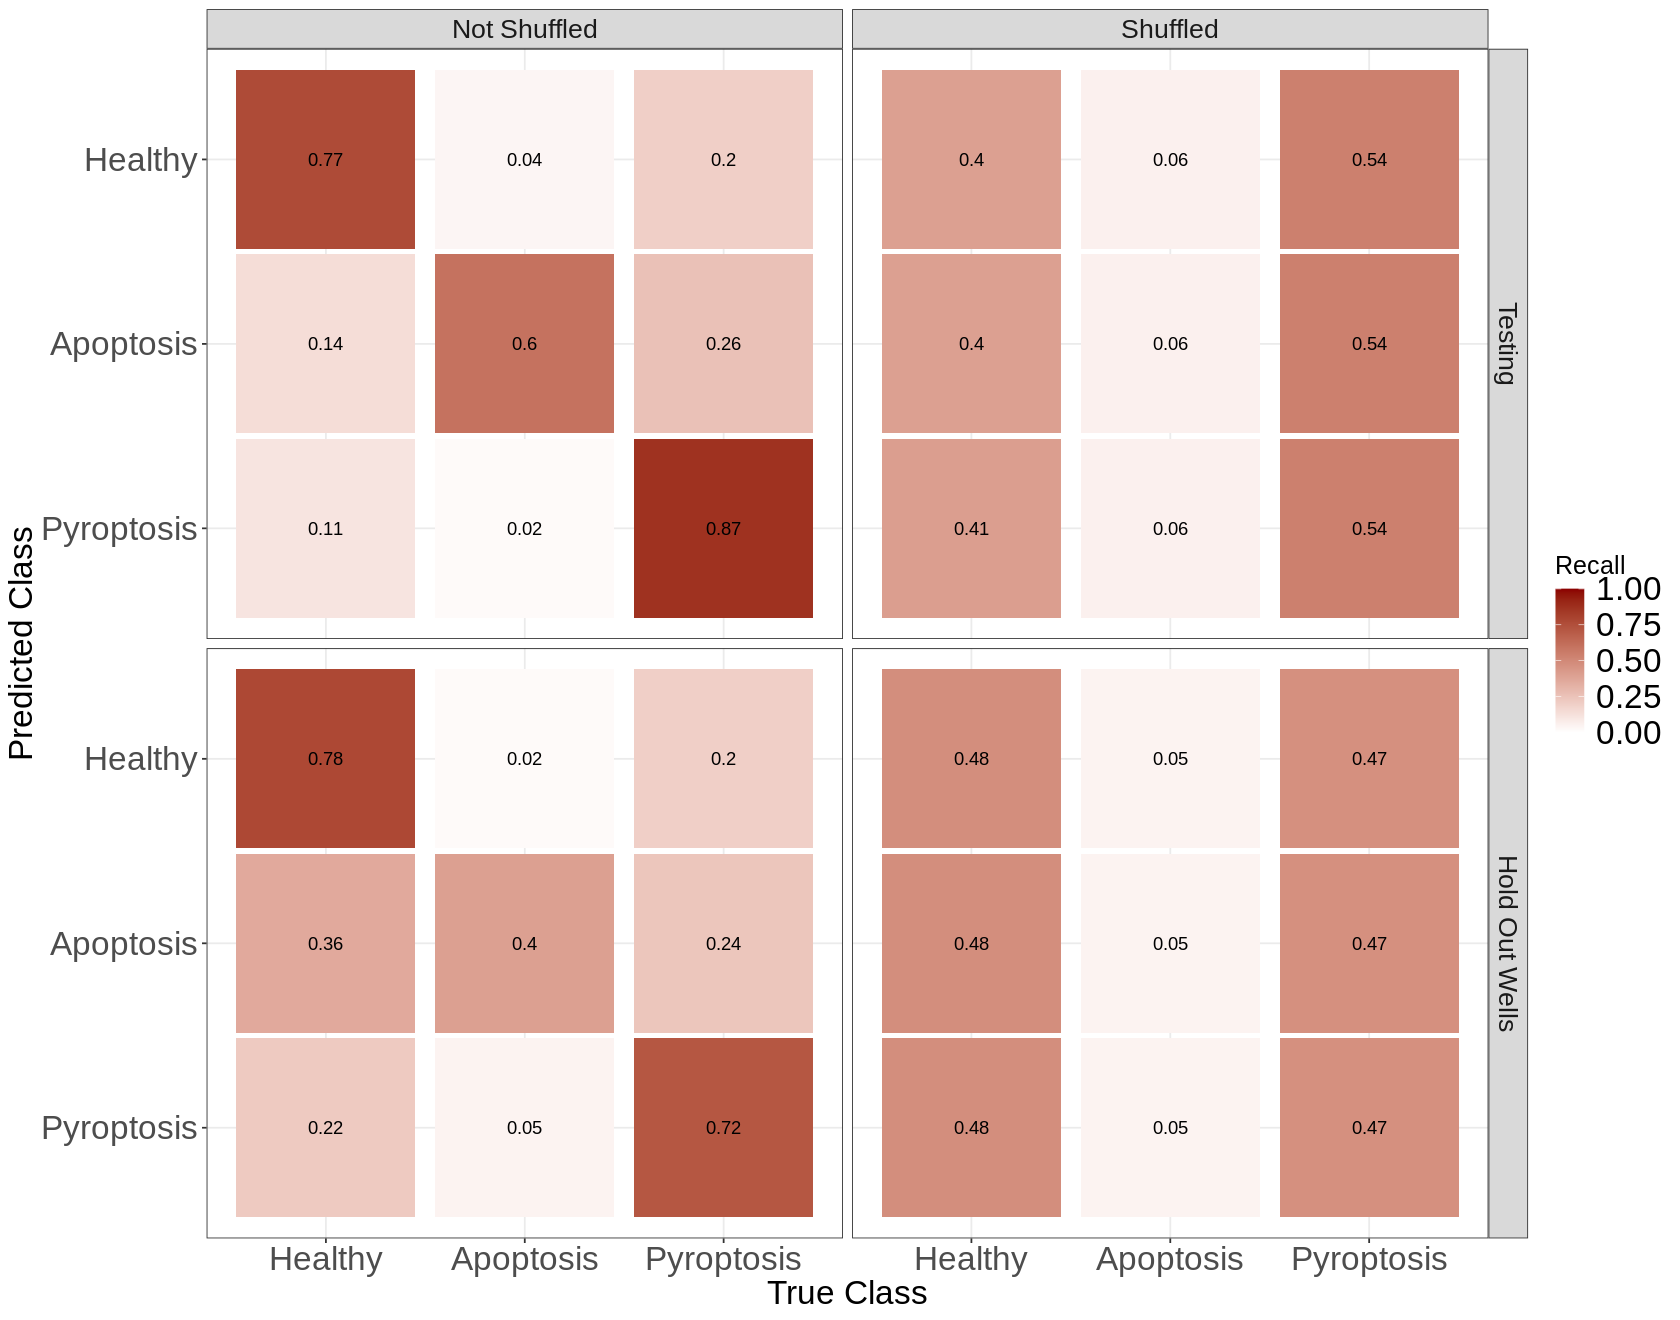

In [47]:
# plot dimensions
width <- 14
height <- 11
options(repr.plot.width = width, repr.plot.height = height)
# plot a confusion matrix
confusion_matrix_plot <- (
    ggplot(confusion_matrix, aes(x = True_Label, y = Predicted_Label))
    + facet_grid(data_split~shuffled_data)
    + geom_point(aes(color = Recall), size = 50, shape = 15)
    + geom_text(aes(label = Recall))
    + scale_color_gradient("Recall", low = "white", high = "dark red",limits = c(0, 1))
    + theme_bw()
    + ylab("Predicted Class")
    + xlab("True Class")
    + figure_theme


)
ggsave(confusion_matrix_plot_path, confusion_matrix_plot, width = width, height = height, dpi = 600)
confusion_matrix_plot
